In [1]:
import glob
import json
import matplotlib.pyplot as plt
import numpy as np
import os


In [2]:
metrics_avg = {'average': 'Balanced Accuracy'}
metrics_r = {'both': 'Accuracy: Both', 'just_main': 'Accuracy: Just Main', 'r-gap': 'Recall Gap'}
metrics_h = {'just_spurious': 'Accuracy: Just Spurious', 'neither': 'Accuracy: Neither', 'h-gap': 'Hallucination Gap'}
metrics_b2s = {'both-main/box': 'Both and Remove Main', 'both-main/pixel-paint': 'Both and In-Paint Main', 'just_spurious+main': 'Just Spurious and Add Main'}
metrics_b2m = {'both-spurious/box': 'Both and Remove Spurious', 'both-spurious/pixel-paint': 'Both and In-Paint Spurious', 'just_main+spurious': 'Just Main and Add Spurious'}
metrics_m2n = {'just_main-main/box': 'Just Main and Remove Main', 'just_main-main/pixel-paint': 'Just Main and In-Paint Main', 'neither+main': 'Neither and Add Main'}
metrics_s2n = {'just_spurious-spurious/box': 'Just Spurious and Remove Spurious', 'just_spurious-spurious/pixel-paint': 'Just Spurious and In-Paint Spurious', 'neither+spurious': 'Neither and Add Spurious'}

METRICS = {}
for group in [metrics_avg, metrics_r, metrics_h, metrics_b2s, metrics_b2m, metrics_m2n, metrics_s2n]:
    for v in group:
        METRICS[v] = group[v]
        
MODES = {'initial-tune': 'Baseline', 'auto-transfer-ptune': 'SPIRE', 'rrr-tune-ptransfer': 'RRR', 'cdep-transfer-ptune': 'CDEP', 'gs-transfer-ptune': 'GS', 'fs-tune-ptune': 'FS', 'qcec-transfer-ptune': 'QCEC', 'simple-transfer-ptune': 'Naive'}

def exclude(metric, mode):
    if mode == 'SPIRE':
        if 'box' in metric or '+' in metric:
            return True
    elif mode == 'Naive':
        if metric == 'both-spurious/box':
            return True
    elif mode == 'GS':
        if 'main' in metric and 'pixel-paint' in metric:
            return True
    elif mode == 'QCEC':
        if 'pixel-paint' in metric:
            return True
    else:
        return False

In [3]:
def get_metric(metric, mode, pair, p, base = '2-Models/Models'):
    pair = pair.replace(' ', '-')
    results_dir = '{}/{}/{}/{}/{}'.format(os.getcwd(), base, pair, p, mode)
    out = []
    for trial_dir in glob.glob('{}/*'.format(results_dir)):
        try:
            with open('{}/results.json'.format(trial_dir), 'r') as f:
                data = json.load(f)
            if metric in data:
                out.append(data[metric])
                
            with open('{}/counterfactual.json'.format(trial_dir), 'r') as f:
                data = json.load(f)
            if metric in data:
                out.append(data[metric]) 
        except:
            pass
        
    return out

# Aggregates across trials
def get_result(metric, mode, pair, ps):
    x = []
    y = []
    x_all = []
    y_all = []
    for p in ps:
        data = get_metric(metric, mode, pair, p)
        if len(data) > 0:
            x.append(p)
            y.append(np.mean(data))
            for v in data:
                x_all.append(p)
                y_all.append(v)
    return x, y, x_all, y_all    

# Aggregates across pairs
def get_trend(metric, mode, pairs, ps):
    x_all = []
    y_all = []
    for pair in pairs:
        x_tmp, y_tmp, _, _ = get_result(metric, mode, pair, ps)
        if len(x_tmp) > 0:
            for v in x_tmp:
                x_all.append(v)
            for v in y_tmp:
                y_all.append(v)
    x_tmp = np.array(x_all)
    y_tmp = np.array(y_all)
    x = []
    y = []
    for p in ps:
        v = y_tmp[np.where(x_tmp == p)]
        if len(v) > 0:
            x.append(p)
            y.append(np.mean(v))
    return x, y, x_all, y_all

        

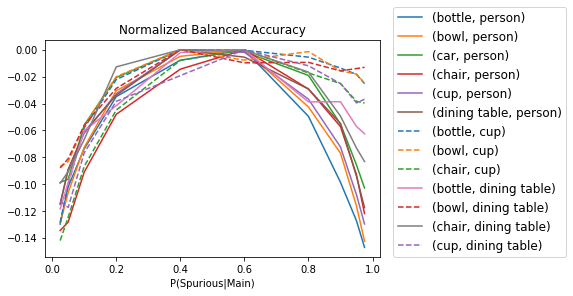

In [4]:
# Determine which pairs will be part of the benchmark
metric = 'average'
mode = 'initial-tune'
pairs = ['bottle person', 'bowl person', 'car person', 'chair person', 'cup person', 'dining+table person', 'bottle cup', 'bowl cup', 'chair cup', 'bottle dining+table', 'bowl dining+table', 'chair dining+table', 'cup dining+table']
ps = [0.025, 0.05, 0.1, 0.2, 0.4, 0.6, 0.8, 0.9, 0.95, 0.975]
cut_off = -0.06

count_accepted = 0
count_rejected = 0
for pair in pairs:    
    x, y, _, _ = get_result(metric, mode, pair, ps)
    if len(y) == len(ps):
        y -= np.max(y) # Normalize

        if y[-1] < cut_off: # Check the gap for p = 0.974
            color = 'C{}'.format(count_accepted)
            linestyle = 'solid'
            count_accepted += 1
        else:
            color = 'C{}'.format(count_rejected)
            linestyle = 'dashed'
            count_rejected += 1

        main = pair.split(' ')[0].replace('+', ' ')
        spurious = pair.split(' ')[1].replace('+', ' ')
        label = '({}, {})'.format(main, spurious)
        plt.plot(x, y, label = label, color = color, linestyle = linestyle)

plt.legend(loc = (1.04, 0), fontsize = 12.0)
plt.xlabel('P(Spurious|Main)')
plt.title('Normalized Balanced Accuracy')
plt.show()
plt.close()


Results averaged across pairs.  Dots represent the individual pairs



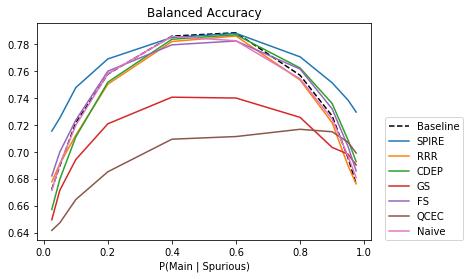

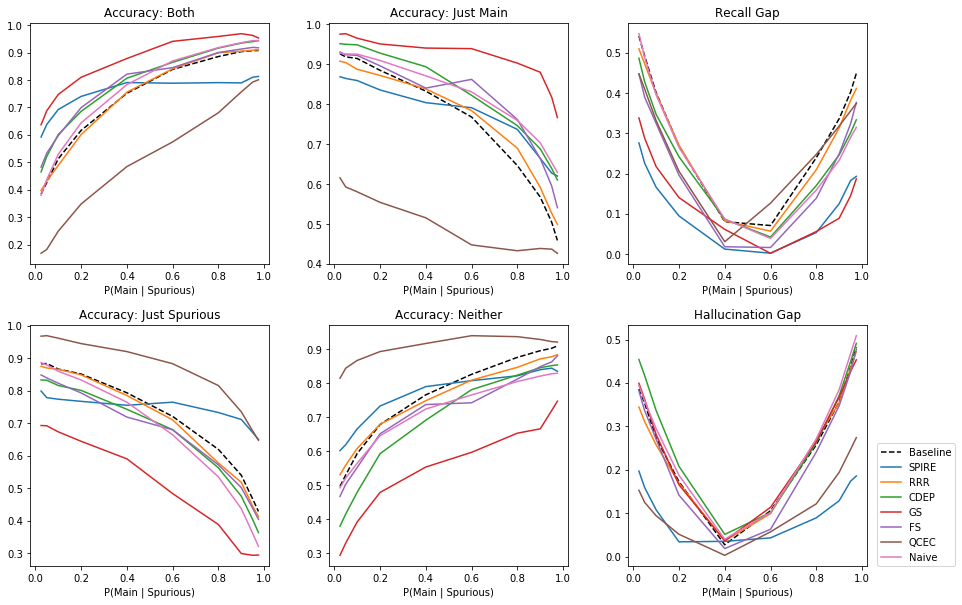

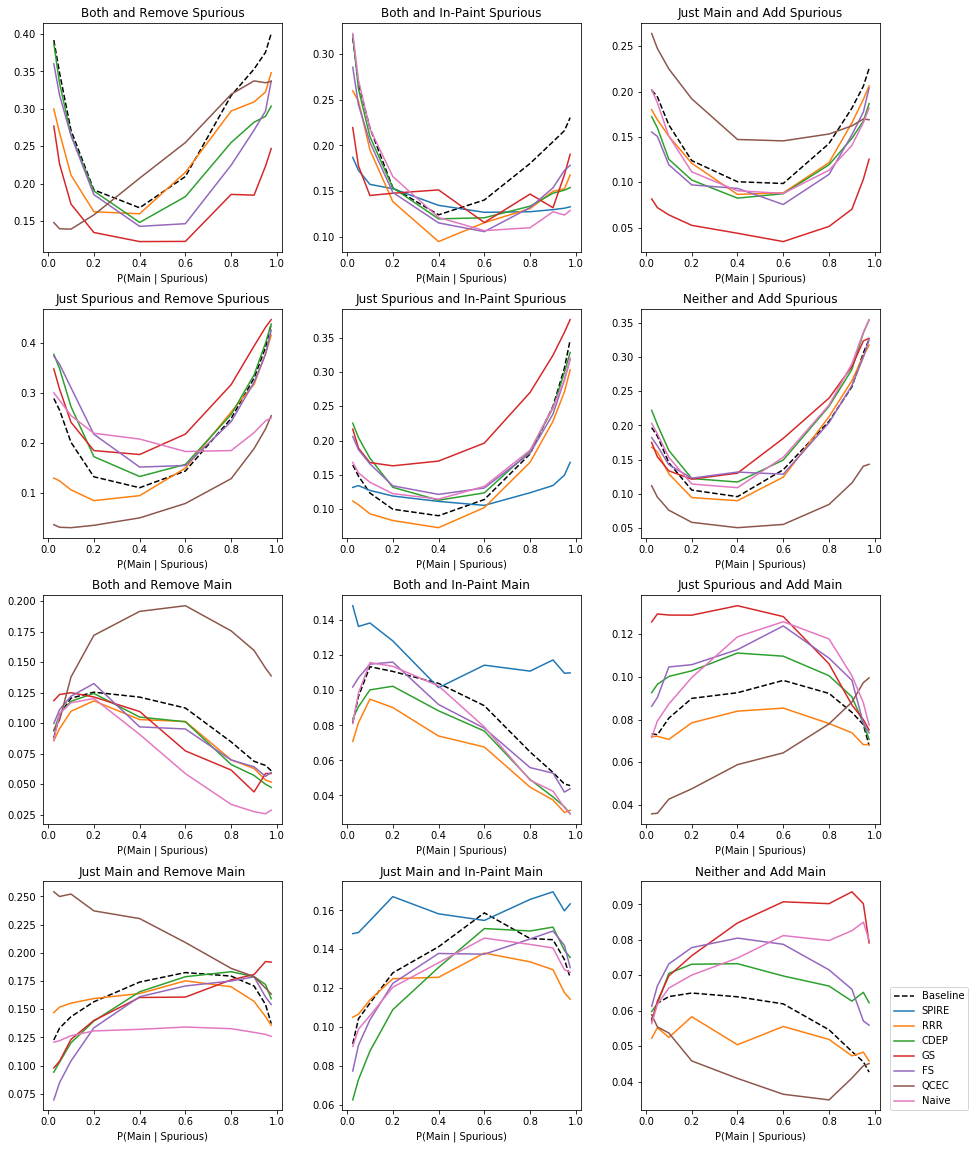

In [5]:
# Compare different training modes in terms of a specific metric across pairs
modes = [key for key in MODES]
pairs = ['bottle person', 'bowl person', 'car person', 'chair person', 'cup person', 'dining+table person', 'bottle dining+table', 'chair dining+table'] 
ps = [0.025, 0.05, 0.1, 0.2, 0.4, 0.6, 0.8, 0.9, 0.95, 0.975]

def compare(metric, modes, pairs, ps, exclude_used = True):
    for mode in modes:
        x, y, x_all, y_all = get_trend(metric, mode, pairs, ps)
        if metric in ['r-gap', 'h-gap']:
            y = np.abs(y)
        mode = MODES[mode]
        if exclude_used and exclude(metric, mode):
            plt.plot([], [], label = mode)
        else:
            if mode == 'Baseline':
                plt.plot(x, y, label = mode, color = 'black', linestyle = 'dashed')
                #plt.scatter(x_all, y_all, alpha = 0.25, color = 'black')
            else:
                plt.plot(x, y, label = mode)
                #plt.scatter(x_all, y_all, alpha = 0.25)

    plt.title(METRICS[metric])
    plt.xlabel('P(Main | Spurious)')


print()
print('Results averaged across pairs.  Dots represent the individual pairs')
print()

compare('average', modes, pairs, ps)
plt.legend(loc = (1.04, 0))
plt.show()
plt.close()

print()
print()

fig = plt.figure(figsize = (15, 10))
fig.subplots_adjust(hspace = 0.25, wspace = 0.25)
index = 1
for metrics in [metrics_r, metrics_h]:
    for metric in metrics:
        plt.subplot(2, 3, index)
        compare(metric, modes, pairs, ps)
        index += 1
plt.legend(loc = (1.04, 0))
plt.show()
plt.close()

print()
print()

fig = plt.figure(figsize = (15, 20))
fig.subplots_adjust(hspace = 0.25, wspace = 0.25)
index = 1
for metrics in [metrics_b2m, metrics_s2n, metrics_b2s, metrics_m2n,]:
    for metric in metrics:
        plt.subplot(4, 3, index)
        compare(metric, modes, pairs, ps)
        index += 1
plt.legend(loc = (1.04, 0))
plt.show()
plt.close()

print()
print()



Results averaged across trials.  Dots represent the individual trials



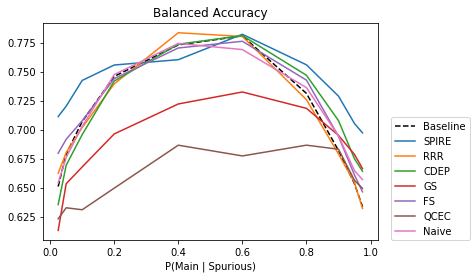

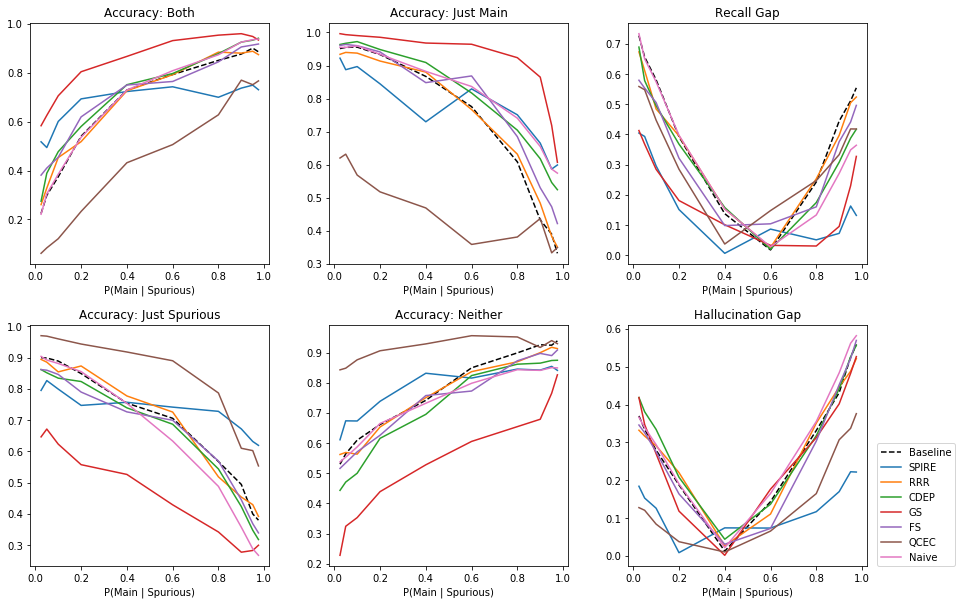

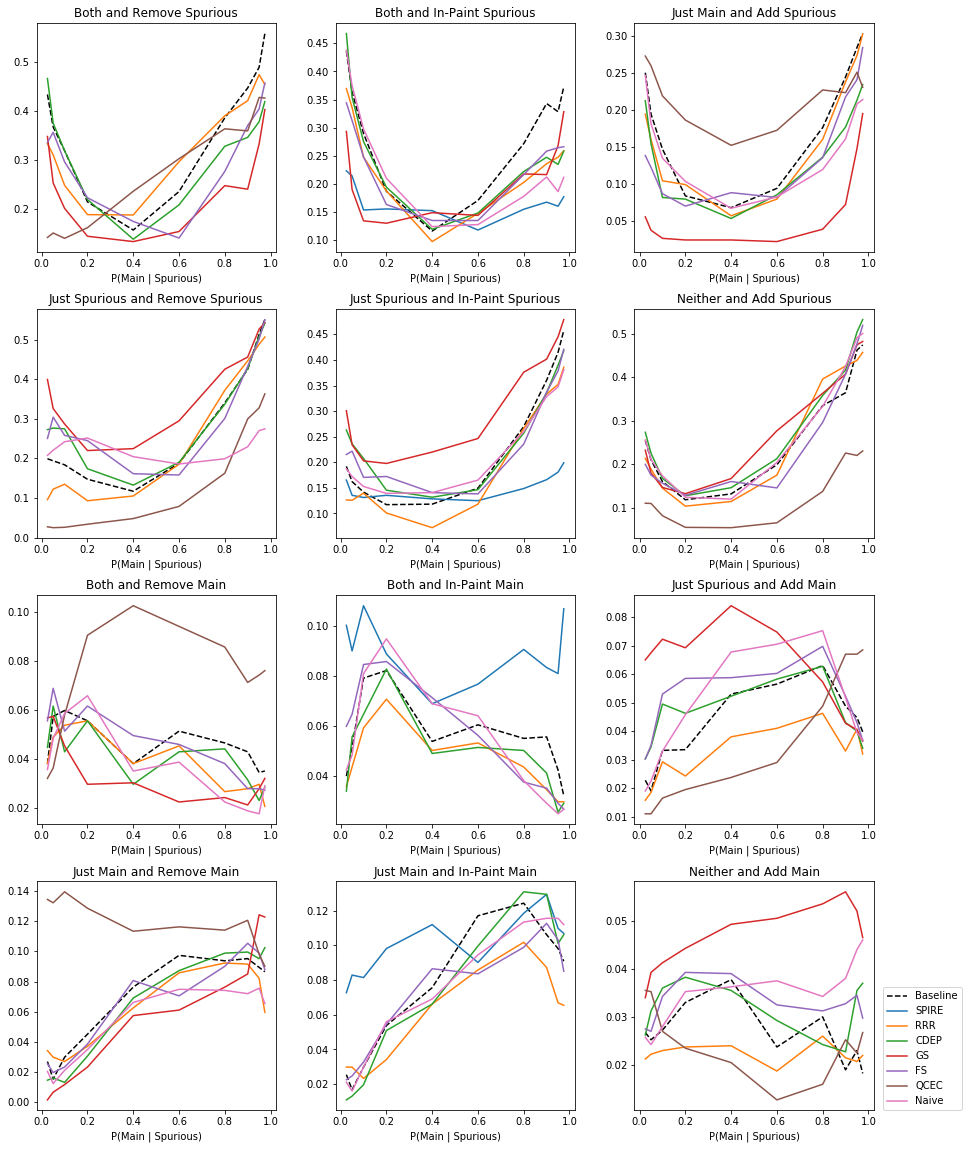

In [6]:
# Compare different training modes in terms of a specific metric for a particular pair
modes = [key for key in MODES]
pair = 'bottle person'
ps = [0.025, 0.05, 0.1, 0.2, 0.4, 0.6, 0.8, 0.9, 0.95, 0.975]

def compare(metric, modes, pair, ps, exclude_used = True):
    for mode in modes:
        x, y, x_all, y_all = get_result(metric, mode, pair, ps)
        if metric in ['r-gap', 'h-gap']:
            y = np.abs(y)
            y_all = np.abs(y_all)
        mode = MODES[mode]
        if exclude_used and exclude(metric, mode):
            plt.plot([], [], label = mode)
        else:
            if mode == 'Baseline':
                plt.plot(x, y, label = mode, color = 'black', linestyle = 'dashed')
                #plt.scatter(x_all, y_all, alpha = 0.25, color = 'black')
            else:
                plt.plot(x, y, label = mode)
                #plt.scatter(x_all, y_all, alpha = 0.25)
    plt.title(METRICS[metric])
    plt.xlabel('P(Main | Spurious)')
    
print()
print('Results averaged across trials.  Dots represent the individual trials')
print()
   
compare('average', modes, pair, ps)
plt.legend(loc = (1.04, 0))
plt.show()
plt.close()

print()
print()

fig = plt.figure(figsize = (15, 10))
fig.subplots_adjust(hspace = 0.25, wspace = 0.25)
index = 1
for metrics in [metrics_r, metrics_h]:
    for metric in metrics:
        plt.subplot(2, 3, index)
        compare(metric, modes, pair, ps)
        index += 1
plt.legend(loc = (1.04, 0))
plt.show()
plt.close()

print()
print()

fig = plt.figure(figsize = (15, 20))
fig.subplots_adjust(hspace = 0.25, wspace = 0.25)
index = 1
for metrics in [metrics_b2m, metrics_s2n, metrics_b2s, metrics_m2n,]:
    for metric in metrics:
        plt.subplot(4, 3, index)
        compare(metric, modes, pair, ps)
        index += 1
plt.legend(loc = (1.04, 0))
plt.show()

print()
print()
